**My project is determine an individual's activity using a smartphone's internal sensors**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import csv
import re
from scipy import stats, integrate
%matplotlib inline

from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn import ensemble
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Why Identify and Label Individual’s Activity?**
The ability of machine to sense, filter, interpret, and possibly mimic human activity and behavior is a widely applicable research field to many industries like healthcare, education etc., Given the pandemic situation that we are in now, I'm interested to see the ablitiy of remote sensors and how it improves the healthcare sectors both from patients and providers perspective since lot of the appointments are happening via video calls these days. 


**What is Human Activity Recognition?** 
"Human Activity Recognition (HAR) is a research field that aims to identify the actions carried out by one or more subjects through the gathering and understanding of context information about the user state and its surrounding environment." source: Kaggle.com, youtube videos

**Research Questions:**
1. Can a individual's activity be accurately predicted from a smart phone's internal sensors? 
2. What variables are most important for a model to predict activity with a smart phone? 
3. Which model most accurately predicts activity with a smart phone?


**Data Gathering**
I pulled a dataset from Kaggle where 30 people participated from ages 19 to 48 used a waist-mounted smartphone as they performed a set of 6 motion sequences: standing, sitting, laying, walking, walking upstairs and walking downstairs. Smart phones are becoming increasingly common around the world and are incorporating more inertial sensors such as accelerometers, gyroscopes and magnetometers. This makes smart phones an ideal tool to reach a large section of the population and is not as restricted by location or battery life.

Sources:

https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones

https://www.youtube.com/watch?v=xjn8LaWR6Mk



In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
train_data = pd.read_csv('gdrive/My Drive/smart_phone_train.csv')
test_data = pd.read_csv('gdrive/My Drive/smart_phone_test.csv')
#test_data = pd.read_csv('test.csv')

train_data.head()


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",...,fBodyBodyAccJerkMag-entropy(),fBodyBodyAccJerkMag-maxInds,fBodyBodyAccJerkMag-meanFreq(),fBodyBodyAccJerkMag-skewness(),fBodyBodyAccJerkMag-kurtosis(),fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-std(),fBodyBodyGyroMag-mad(),fBodyBodyGyroMag-max(),fBodyBodyGyroMag-min(),fBodyBodyGyroMag-sma(),fBodyBodyGyroMag-energy(),fBodyBodyGyroMag-iqr(),fBodyBodyGyroMag-entropy(),fBodyBodyGyroMag-maxInds,fBodyBodyGyroMag-meanFreq(),fBodyBodyGyroMag-skewness(),fBodyBodyGyroMag-kurtosis(),fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-std(),fBodyBodyGyroJerkMag-mad(),fBodyBodyGyroJerkMag-max(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-sma(),fBodyBodyGyroJerkMag-energy(),fBodyBodyGyroJerkMag-iqr(),fBodyBodyGyroJerkMag-entropy(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,-0.567378,-0.744413,0.852947,0.685845,0.814263,-0.965523,-0.999945,-0.999863,-0.994612,-0.994231,-0.987614,-0.943220,-0.407747,-0.679338,-0.602122,0.929294,-0.853011,0.359910,-0.058526,0.256892,-0.224848,0.264106,-0.095246,0.278851,-0.465085,0.491936,-0.190884,0.376314,0.435129,0.660790,...,-1.0,-0.936508,0.346989,-0.516080,-0.802760,-0.980135,-0.961309,-0.973653,-0.952264,-0.989498,-0.980135,-0.999240,-0.992656,-0.701291,-1.000000,-0.128989,0.586156,0.374605,-0.991990,-0.990697,-0.989941,-0.992448,-0.991048,-0.991990,-0.999937,-0.990458,-0.871306,-1.000000,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,-0.557851,-0.818409,0.849308,0.685845,0.822637,-0.981930,-0.999991,-0.999788,-0.998405,-0.999150,-0.977866,-0.948225,-0.714892,-0.500930,-0.570979,0.611627,-0.329549,0.284213,0.284595,0.115705,-0.090963,0.294310,-0.281211,0.085988,-0.022153,-0.016657,-0.220643,-0.013429,-0.072692,0.579382,...,-1.0,-0.841270,0.532061,-0.624871,-0.900160,-0.988296,-0.983322,-0.982659,-0.986321,-0.991829,-0.988296,-0.999811,-0.993979,-0.720683,-0.948718,-0.271958,-0.336310,-0.720015,-0.995854,-0.996399,-0.995442,-0.996866,-0.994440,-0.995854,-0.999981,-0.994544,-1.000000,-1.000000,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,-0.557851,-0.818409,0.843609,0.682401,0.839344,-0.983478,-0.999969,-0.999660,-0.999470,-0.997130,-0.964810,-0.974675,-0.592235,-0.485821,-0.570979,0.273025,-0.086309,0.337202,-0.164739,0.017150,-0.074507,0.342256,-0.332564,0.239281,-0.136204,0.173863,-0.299493,-0.124698,-0.181105,0.608900,...,-1.0,-0.904762,0.660795,-0.724697,-0.928539,-0.989255,-0.986028,-0.984274,-0.990979,-0.995703,-0.989255,-0.999854,-0.993238,-0.736521,-0

**Data Modeling**
This dataset has a very large number of features. I'll try to explain in a few how the data was recorded and analyze. The features used in this database come from the accelerometer and gyroscope 3-axial raw signals. 
The 'XYZ' is used to denote 3-axial signals in the X, Y and Z directions. The prefix 't' refers to time and it was recorded at 50 Hertz or 20 milliseconds. The acceleration signal was then separated into body and gravity acceleration signals. The body linear acceleration and angular velocity were derived in time to obtain Jerk signals. Then the magnitude of these three-dimensional signals were calculated. Lastly a 'f' indicates frequency, or the features where a Fast Fourier Transform (FFT) algorithm was applied to some of these signals to find the frequency of the domain signals.

Further details:

Features are normalized and bounded within [-1,1].
Each feature vector is a row on the 'X' and 'y' files.
The units used for the accelerations (total and body) are 'g's (gravity of earth -> 9.80665 m/seg2).
The gyroscope units are rad/seg.

In [5]:
print(train_data.shape)
print(test_data.shape)

(7352, 563)
(2947, 563)


In [6]:
# Check if there are any NULL values in the dataset
print(train_data.isnull().sum())

tBodyAcc-mean()-X       0
tBodyAcc-mean()-Y       0
tBodyAcc-mean()-Z       0
tBodyAcc-std()-X        0
tBodyAcc-std()-Y        0
                       ..
angle(X,gravityMean)    0
angle(Y,gravityMean)    0
angle(Z,gravityMean)    0
subject                 0
Activity                0
Length: 563, dtype: int64


In [7]:
train_data.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",...,fBodyBodyAccJerkMag-iqr(),fBodyBodyAccJerkMag-entropy(),fBodyBodyAccJerkMag-maxInds,fBodyBodyAccJerkMag-meanFreq(),fBodyBodyAccJerkMag-skewness(),fBodyBodyAccJerkMag-kurtosis(),fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-std(),fBodyBodyGyroMag-mad(),fBodyBodyGyroMag-max(),fBodyBodyGyroMag-min(),fBodyBodyGyroMag-sma(),fBodyBodyGyroMag-energy(),fBodyBodyGyroMag-iqr(),fBodyBodyGyroMag-entropy(),fBodyBodyGyroMag-maxInds,fBodyBodyGyroMag-meanFreq(),fBodyBodyGyroMag-skewness(),fBodyBodyGyroMag-kurtosis(),fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-std(),fBodyBodyGyroJerkMag-mad(),fBodyBodyGyroJerkMag-max(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-sma(),fBodyBodyGyroJerkMag-energy(),fBodyBodyGyroJerkMag-iqr(),fBodyBodyGyroJerkMag-entropy(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject
count,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,...,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000
mean,0.274488,-0.017695,-0.109141,-0.605438,-0.510938,-0.604754,-0.630512,-0.526907,-0.606150,-0.468604,-0.306043,-0.557121,0.523551,0.387386,0.594374,-0.547569,-0.820041,-0.901874,-0.845784,-0.684345,-0.643770,-0.631069,-0.102993,-0.137937,-0.163946,-0.116599,0.102762,-0.037786,0.130477,-0.026229,0.026322,0.159966,-0.019575,0.009420,0.033291,0.036587,-0.078640,-0.125131,-0.193802,0.105005,...,-0.678618,-0.347657,-0.877995,0.178195,-0.312968,-0.615441,-0.693210,-0.692876,-0.674830,-0.726645,-0.885103,-0.693210,-0.874292,-0.719795,-0.087878,-0.889442,-0.046516,-0.253649,-0.565425,-0.779376,-0.792391,-0.772836,-0.811409,-0.871927,-0.779376,-0.935785,-0.771497,-0.284627,-0.898859,0.125293,-0.307009,-0.625294,0.008684,0.002186,0.008726,-0.005981,-0.489547,0.058593,-0.056515,17.413085
std,0.070261,0.040811,0.056635,0.448734,0.502645,0.418687,0.424073,0.485942,0.414122,0.544547,0.282243,0.293867,0.363594,0.343611,0.297818,0.471808,0.259607,0.126333,0.221983,0.371608,0.371581,0.386569,0.468959,0.437268,0.371363,0.306507,0.246593,0.243635,0.230067,0.257383,0.215001,0.208837,0.221432,0.


**Feature Distribution**
Since the acceleration and energy features play a key role in montioring the activity, we will begin to visualize the relationship of the elationship of the 'Gravity Acceleration' and 'Gravity Energy' features to each type of activity. This is to display how an distinction can be identified between these features and the corresponding activities.

In [10]:
np.unique(train_data['Activity'])

array(['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

In [12]:
laying_df = train_data[train_data['Activity'] == 'LAYING']
sitting_df = train_data[train_data['Activity'] == 'SITTING']
standing_df = train_data[train_data['Activity'] == 'STANDING']
walking_df = train_data[train_data['Activity'] == 'WALKING']
walkingDOWN_df = train_data[train_data['Activity'] == 'WALKING_DOWNSTAIRS']
walkingUP_df = train_data[train_data['Activity'] == 'WALKING_UPSTAIRS']

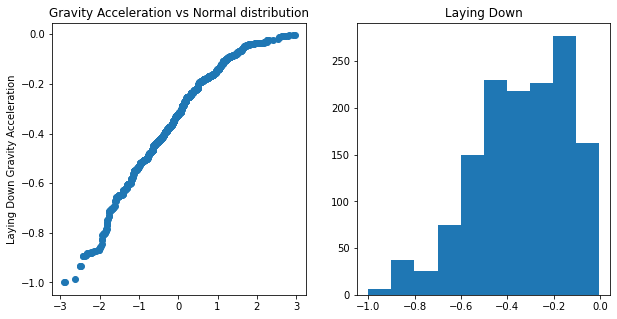

In [13]:
modeling_list = [laying_df]

#Visualizing all the continuous data points with a QQ polt and a histogram
for each in modeling_list:
    #Set up the figure size
    f, ax = plt.subplots(figsize=(10, 5))
    plt.subplot(1, 2, 1)
            
    #Sort the values from the dataset
    result = each['tGravityAcc-min()-X'].sort_values()
    #Create a normal distribution variable
    norm = np.random.normal(0, 1, len(each))
    #Sort the values of the normal distribution
    norm.sort()
    #Create the QQ plot
    plt.plot(norm, result, "o")
    plt.ylabel('Laying Down Gravity Acceleration')
    plt.title('Gravity Acceleration vs Normal distribution')
            
    #Create the histogram of the dataset
    plt.subplot(1, 2, 2)
    plt.hist(result)
    plt.title('Laying Down')

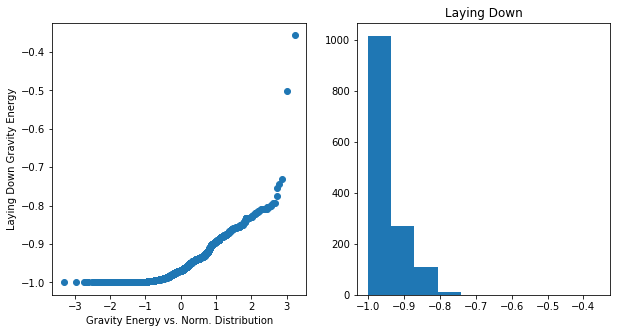

In [14]:
modeling_list = [laying_df]

for i in modeling_list:
    f,ax = plt.subplots(figsize=(10,5))
    plt.subplot(1,2,1)

    #Sort the values
    result=i['tGravityAcc-energy()-X'].sort_values()
    #Create normal distribution
    norm=np.random.normal(0,1,len(i))
    norm.sort()
    #Create QQ plot
    plt.plot(norm,result,"o")
    plt.ylabel("Laying Down Gravity Energy")
    plt.xlabel('Gravity Energy vs. Norm. Distribution')

    #Histogram
    plt.subplot(1,2,2)
    plt.hist(result)
    plt.title('Laying Down')

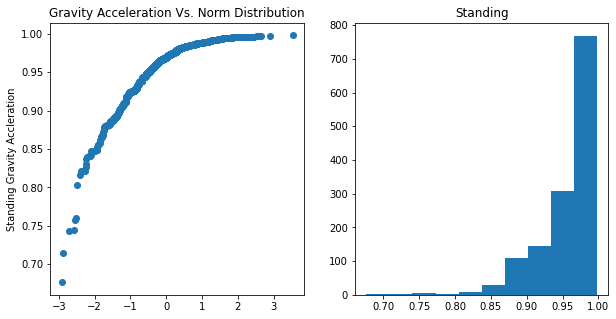

In [15]:
modeling_list = [standing_df]

for i in modeling_list:
    f, ax = plt.subplots(figsize=(10,5))
    plt.subplot(1,2,1)

    #sort values
    result = i['tGravityAcc-min()-X'].sort_values()
    norm=np.random.normal(0,1,len(i))
    norm.sort()

    #QQplot
    plt.plot(norm,result,'o')
    plt.ylabel('Standing Gravity Accleration')
    plt.title('Gravity Acceleration Vs. Norm Distribution')

    #Histogram
    plt.subplot(1,2,2)
    plt.hist(result)
    plt.title('Standing')

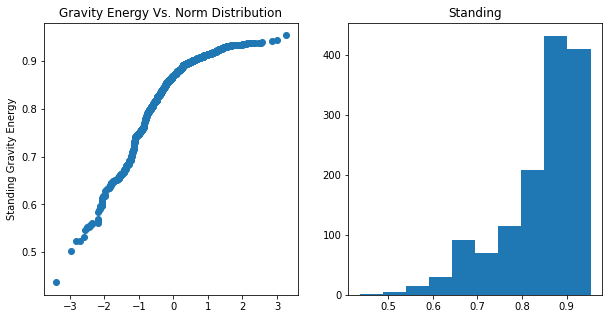

In [16]:
modeling_list = [standing_df]

for i in modeling_list:
    f, ax = plt.subplots(figsize=(10,5))
    plt.subplot(1,2,1)

    #sort values
    result = i['tGravityAcc-energy()-X'].sort_values()
    norm=np.random.normal(0,1,len(i))
    norm.sort()

    #QQplot
    plt.plot(norm,result,'o')
    plt.ylabel('Standing Gravity Energy')
    plt.title('Gravity Energy Vs. Norm Distribution')

    #Histogram
    plt.subplot(1,2,2)
    plt.hist(result)
    plt.title('Standing')

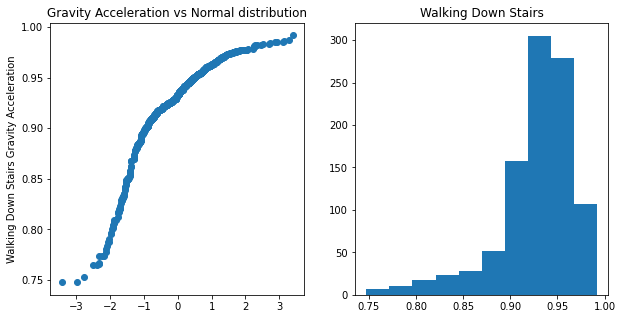

In [19]:
modeling_list = [walkingDOWN_df]
#Visualizing all the continuous data points with a QQ polt and a histogram
for i in modeling_list:
    #Set up the figure size
    f, ax = plt.subplots(figsize=(10, 5))
    plt.subplot(1, 2, 1)
            
    #Sort the values from the dataset
    result = i['tGravityAcc-min()-X'].sort_values()
    #Create a normal distribution variable
    norm = np.random.normal(0, 1, len(i))
    #Sort the values of the normal distribution
    norm.sort()
    #Create the QQ plot
    plt.plot(norm, result, "o")
    plt.ylabel('Walking Down Stairs Gravity Acceleration')
    plt.title('Gravity Acceleration vs Normal distribution')
            
    #Create the histogram of the dataset
    plt.subplot(1, 2, 2)
    plt.hist(result)
    plt.title('Walking Down Stairs')

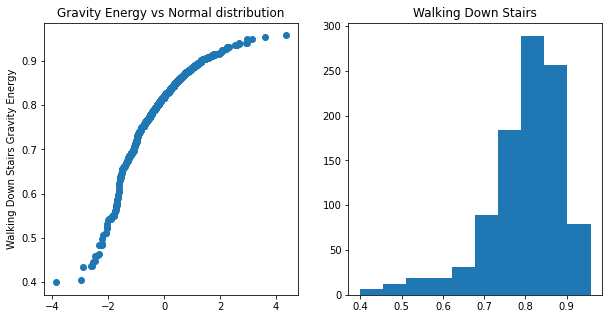

In [ ]:
modeling_list = [walkingDOWN_df]

#Visualizing all the continuous data points with a QQ polt and a histogram
for i in modeling_list:
    #Set up the figure size
    f, ax = plt.subplots(figsize=(10, 5))
    plt.subplot(1, 2, 1)
            
    #Sort the values from the dataset
    result = i['tGravityAcc-energy()-X'].sort_values()
    #Create a normal distribution variable
    norm = np.random.normal(0, 1, len(i))
    #Sort the values of the normal distribution
    norm.sort()
    #Create the QQ plot
    plt.plot(norm, result, "o")
    plt.ylabel('Walking Down Stairs Gravity Energy')
    plt.title('Gravity Energy vs Normal distribution')
            
    #Create the histogram of the dataset
    plt.subplot(1, 2, 2)
    plt.hist(result)
    plt.title('Walking Down Stairs')

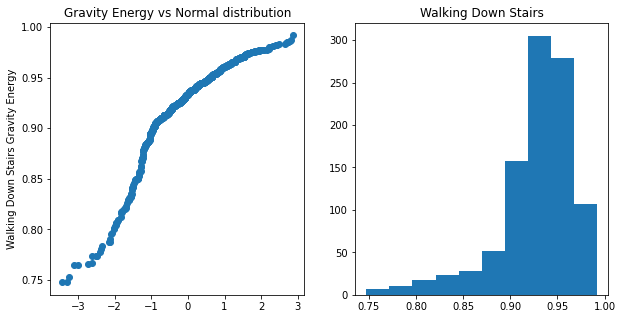

In [ ]:
modeling_list = [walkingDOWN_df]

#Visualizing all the continuous data points with a QQ polt and a histogram
for i in modeling_list:
    #Set up the figure size
    f, ax = plt.subplots(figsize=(10, 5))
    plt.subplot(1, 2, 1)
            
    #Sort the values from the dataset
    result = i['tGravityAcc-min()-X'].sort_values()
    #Create a normal distribution variable
    norm = np.random.normal(0, 1, len(i))
    #Sort the values of the normal distribution
    norm.sort()
    #Create the QQ plot
    plt.plot(norm, result, "o")
    plt.ylabel('Walking Down Stairs Gravity Energy')
    plt.title('Gravity Energy vs Normal distribution')
            
    #Create the histogram of the dataset
    plt.subplot(1, 2, 2)
    plt.hist(result)
    plt.title('Walking Down Stairs')

**Dataset Balance**

Before modeling my dataset, I want to check if the data is well balanced between the various activities and subject participants

In [ ]:
for i in np.unique(train_data['Activity']):
    print(i)
    print("{}%".format(round((len(train_data[train_data['Activity'] == i])/len(train_data)) * 100)))

LAYING
19%
SITTING
17%
STANDING
19%
WALKING
17%
WALKING_DOWNSTAIRS
13%
WALKING_UPSTAIRS
15%


In [ ]:
for i in np.unique(train_data['subject']):
    print("subject {}".format(i))
    print("{}%".format(round((len(train_data[train_data['subject'] == i])/len(train_data)) * 100)))

subject 1
5%
subject 3
5%
subject 5
4%
subject 6
4%
subject 7
4%
subject 8
4%
subject 11
4%
subject 14
4%
subject 15
4%
subject 16
5%
subject 17
5%
subject 19
5%
subject 21
6%
subject 22
4%
subject 23
5%
subject 25
6%
subject 26
5%
subject 27
5%
subject 28
5%
subject 29
5%
subject 30
5%


Based on the above output, the data seem to be well balanced. 


**Multiclass Classification Modeling**  
Because one of my research questions is about finding which variables are most important for model prediction, I will start with explanatory models. Additionally, my models are limited to a multiclass classification selection because of the nature of the dataset.

In [22]:
# The outcomes of interest for both the train and test dataset

train_Y = train_data['Activity']
test_Y = test_data['Activity']

In [23]:
#Drop Subject and Acivity from features
train_data = train_data.drop(['subject', 'Activity'], axis=1)
test_data = test_data.drop(['subject', 'Activity'], axis=1)

**RANDOM FOREST CLASSIFER**

In [24]:
rfc = ensemble.RandomForestClassifier()
rfc.fit(train_data,train_Y)
print("Report:")
y_true,y_pred = test_Y, rfc.predict(test_data)
print(classification_report(y_true,y_pred))
confusion_matrix(y_true,y_pred)
#mat=confusion_matrix(y_true,y_pred)
#mat = confusion_matrix(y_true,y_pred)
#plot_confusion_matrix(mat, label.classes_,title='confusionMatrix')

Report:
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.91      0.87      0.89       491
          STANDING       0.88      0.92      0.90       532
           WALKING       0.91      0.96      0.93       496
WALKING_DOWNSTAIRS       0.95      0.84      0.89       420
  WALKING_UPSTAIRS       0.89      0.93      0.91       471

          accuracy                           0.92      2947
         macro avg       0.92      0.92      0.92      2947
      weighted avg       0.92      0.92      0.92      2947



array([[537,   0,   0,   0,   0,   0],
       [  0, 426,  65,   0,   0,   0],
       [  0,  40, 492,   0,   0,   0],
       [  0,   0,   0, 478,  11,   7],
       [  0,   0,   0,  20, 351,  49],
       [  0,   0,   0,  29,   6, 436]])

In [25]:
RFC_score = cross_val_score(rfc, test_data, test_Y, cv=5)
print('\nEach cross validated accuracy: \n', RFC_score)
print("\n Overall RF classifier Accuracy: %0.2f (+/- %0.2f)\n" % (RFC_score.mean(), RFC_score.std() *2))


Each cross validated accuracy: 
 [0.93898305 0.85423729 0.92359932 0.88964346 0.92529711]

 Overall RF classifier Accuracy: 0.91 (+/- 0.06)



In [26]:

# Saving the feature names
feature_list = list(test_data.columns)
# Get numerical feature importances
importances = list(rfc.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: tGravityAcc-min()-X  Importance: 0.04
Variable: tGravityAcc-mean()-X Importance: 0.03
Variable: tGravityAcc-min()-Y  Importance: 0.03
Variable: tGravityAcc-energy()-X Importance: 0.03
Variable: angle(Y,gravityMean) Importance: 0.03
Variable: tGravityAcc-mean()-Y Importance: 0.02
Variable: tGravityAcc-max()-X  Importance: 0.02
Variable: tGravityAcc-max()-Y  Importance: 0.02
Variable: tGravityAcc-energy()-Y Importance: 0.02
Variable: angle(X,gravityMean) Importance: 0.02
Variable: tBodyAcc-max()-X     Importance: 0.01
Variable: tBodyAcc-energy()-X  Importance: 0.01
Variable: tBodyAcc-correlation()-X,Y Importance: 0.01
Variable: tGravityAcc-mean()-Z Importance: 0.01
Variable: tGravityAcc-max()-Z  Importance: 0.01
Variable: tGravityAcc-min()-Z  Importance: 0.01
Variable: tGravityAcc-energy()-Z Importance: 0.01
Variable: tGravityAcc-entropy()-Y Importance: 0.01
Variable: tGravityAcc-arCoeff()-X,1 Importance: 0.01
Variable: tGravityAcc-arCoeff()-X,2 Importance: 0.01
Variable: tGrav

In [27]:
feature_importances = feature_importances[:20]
importance = []
importance_name = []
for each in feature_importances:
    importance.append(round(each[1], 2))
    importance_name.append(each[0])

In [28]:
feature_importances

[('tGravityAcc-min()-X', 0.04),
 ('tGravityAcc-mean()-X', 0.03),
 ('tGravityAcc-min()-Y', 0.03),
 ('tGravityAcc-energy()-X', 0.03),
 ('angle(Y,gravityMean)', 0.03),
 ('tGravityAcc-mean()-Y', 0.02),
 ('tGravityAcc-max()-X', 0.02),
 ('tGravityAcc-max()-Y', 0.02),
 ('tGravityAcc-energy()-Y', 0.02),
 ('angle(X,gravityMean)', 0.02),
 ('tBodyAcc-max()-X', 0.01),
 ('tBodyAcc-energy()-X', 0.01),
 ('tBodyAcc-correlation()-X,Y', 0.01),
 ('tGravityAcc-mean()-Z', 0.01),
 ('tGravityAcc-max()-Z', 0.01),
 ('tGravityAcc-min()-Z', 0.01),
 ('tGravityAcc-energy()-Z', 0.01),
 ('tGravityAcc-entropy()-Y', 0.01),
 ('tGravityAcc-arCoeff()-X,1', 0.01),
 ('tGravityAcc-arCoeff()-X,2', 0.01)]

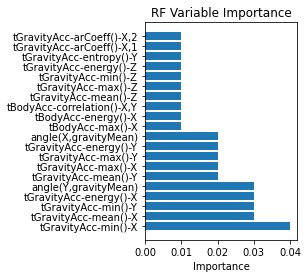

In [29]:
# take the top 20 most important features
sorted_idx = np.argsort(feature_importances)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, importance, align='center')
plt.yticks(pos, importance_name)
plt.xlabel('Importance')
plt.title('RF Variable Importance')
plt.show()

**Gradient Boosting Classifer**




In [30]:
clf=ensemble.GradientBoostingClassifier(loss='deviance')
clf.fit(train_data,train_Y)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [35]:
print("Report:")
y_true, y_pred = test_Y, clf.predict(test_data)
print(classification_report(y_true,y_pred))
confusion_matrix(y_true,y_pred)

Report:
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.92      0.85      0.89       491
          STANDING       0.88      0.94      0.91       532
           WALKING       0.94      0.98      0.96       496
WALKING_DOWNSTAIRS       0.97      0.92      0.95       420
  WALKING_UPSTAIRS       0.93      0.93      0.93       471

          accuracy                           0.94      2947
         macro avg       0.94      0.94      0.94      2947
      weighted avg       0.94      0.94      0.94      2947



array([[537,   0,   0,   0,   0,   0],
       [  0, 419,  69,   0,   0,   3],
       [  0,  33, 499,   0,   0,   0],
       [  0,   0,   0, 486,   5,   5],
       [  0,   0,   0,   7, 387,  26],
       [  0,   1,   0,  26,   6, 438]])

In [36]:
CLF_score = cross_val_score(clf, test_data, test_Y, cv=5)
print('\nEach Cross Validated Accuracy: \n', CLF_score)
print("\nOverall Gradient Boosted Classifier Accuracy: %0.2f (+/- %0.2f)\n" % (CLF_score.mean(), CLF_score.std() * 2))


Each Cross Validated Accuracy: 
 [0.92542373 0.84067797 0.95925297 0.91171477 0.96264856]

Overall Gradient Boosted Classifier Accuracy: 0.92 (+/- 0.09)



In [ ]:
# Saving the feature names
feature_list = list(test_data.columns)
# Get numerical feature importances
importances = list(clf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

In [ ]:
feature_importances = feature_importances[:20]
importance = []
importance_list = []
for each in feature_importances:
    importance.append(round(each[1], 2))
    importance_list.append(each[0])

In [ ]:
feature_importances

[('tGravityAcc-min()-X', 0.24),
 ('angle(Y,gravityMean)', 0.07),
 ('tGravityAcc-max()-Y', 0.05),
 ('tBodyAcc-max()-X', 0.04),
 ('fBodyAccMag-mad()', 0.04),
 ('tGravityAcc-min()-Y', 0.03),
 ('tBodyGyro-max()-X', 0.03),
 ('tBodyGyroJerk-mad()-X', 0.03),
 ('fBodyAcc-skewness()-X', 0.03),
 ('fBodyAcc-bandsEnergy()-1,8', 0.03),
 ('fBodyAccMag-std()', 0.03),
 ('fBodyAccMag-energy()', 0.03),
 ('tGravityAcc-arCoeff()-Z,1', 0.02),
 ('fBodyAcc-max()-X', 0.02),
 ('fBodyAcc-bandsEnergy()-1,8.1', 0.02),
 ('fBodyAcc-bandsEnergy()-1,8.2', 0.02),
 ('fBodyGyro-maxInds-Z', 0.02),
 ('fBodyBodyAccJerkMag-max()', 0.02),
 ('angle(X,gravityMean)', 0.02),
 ('tBodyAcc-correlation()-X,Y', 0.01)]

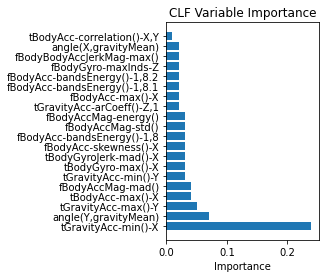

In [ ]:
sorted_idx = np.argsort(feature_importances)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, importance, align='center')
plt.yticks(pos, importance_list)
plt.xlabel('Importance')
plt.title('CLF Variable Importance')
plt.show()

**Support Vector Classifier**

In [31]:
svc = SVC(kernel='linear')
svc.fit(train_data,train_Y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [32]:
print("Report:")
y_true, y_pred = test_Y, svc.predict(test_data)
print(classification_report(y_true, y_pred))
confusion_matrix(y_true, y_pred)

Report:
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.96      0.89      0.92       491
          STANDING       0.91      0.97      0.94       532
           WALKING       0.96      0.99      0.97       496
WALKING_DOWNSTAIRS       0.99      0.98      0.98       420
  WALKING_UPSTAIRS       0.98      0.96      0.97       471

          accuracy                           0.96      2947
         macro avg       0.97      0.96      0.96      2947
      weighted avg       0.96      0.96      0.96      2947



array([[537,   0,   0,   0,   0,   0],
       [  0, 435,  54,   0,   0,   2],
       [  0,  16, 516,   0,   0,   0],
       [  0,   0,   0, 492,   3,   1],
       [  0,   0,   0,   4, 410,   6],
       [  0,   0,   0,  18,   2, 451]])

In [33]:
SVC_score = cross_val_score(svc, test_data, test_Y, cv=5)
print('\nEach Cross Validated Accuracy: \n', SVC_score)
print("\nOverall Support Vector Classifier Accuracy: %0.2f (+/- %0.2f)\n" % (SVC_score.mean(), SVC_score.std() * 2))


Each Cross Validated Accuracy: 
 [0.97118644 0.86779661 0.94397284 0.93378608 0.93378608]

Overall Support Vector Classifier Accuracy: 0.93 (+/- 0.07)



**Conclusion**:

Summarizing my research questions:

1. Can the activity of a individual be accurately predicted from a smart phone's internal sensors?

2. What variables are most important for a model to predict activity with a smart phone?

3. Which model most accurately predicts activity with a smart phone? 

This Capstone project provided an interesting opportunity to poke into the Human Activity Recognition dataset. This is equally an interesting and challenging dataset, especially how human activities are tracked using IoT sensors and the sensors are playing a more engaging and prominent role in many industries these days. 

To return to my goals for this project, the Support Vector Classifier was able to achieve an R-squared values of 0.93 for predicting human activity from a smart phone's internal sensors.

The Support Vector Machine is very versatile and great as a classifier but it comes at the cost of explaining which features are most important in my dataset. So if my goal was to only create a model with very accurate predictions, I would choose the SVM because it was able to achieve the highest average accuracy of 0.96. On the same note, If I want a more explanatory model, then I'd go with e Gradient Boosting and Random Forest Classifiers as possible options. While both of these models are still less informative than what the  logistic regression model would be, but they gave an overall accurate predictions and some information about which variables are most important for predicting the outcome. For instance, the three most commonly used features for both the Gradient Boosting and Random Forest models were about Gravity Acceleration.

A few possible improvements: 
Since the dataset has so many features, I'd like to focus more on optimizing the dataset, if I had more time. Also, more explanatory models using this dataset would help derive better models and identify the key distinctions between activities as well. 